In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LSTM, TimeDistributed, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import SMOTE
import warnings                   # Ignore all warnings.
warnings.filterwarnings("ignore")

In [7]:
# Load dataset
data = pd.read_csv('data/fer2013.csv')

In [8]:
# Display dataset content and number of images per class
print("Dataset Content:")
print(data.head())

Dataset Content:
   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training


In [9]:
print("\nNumber of images per emotion:")
print(data['emotion'].value_counts())

print("\n0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral\n")

print(data['Usage'].value_counts())


Number of images per emotion:
emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64


In [10]:
# Preprocess combined data based on usage
def preprocess_data_based_on_usage(data, usage_type):
    data = data[data['Usage'] == usage_type]
    pixels = data['pixels'].tolist()
    width, height = 48, 48
    faces = [np.array([int(pixel) for pixel in pixel_sequence.split(' ')]) for pixel_sequence in pixels]
    faces = np.array(faces)
    faces = faces.reshape((faces.shape[0], width, height, 1))
    faces = faces / 255.0  # Normalize pixel values
    emotions = to_categorical(data['emotion'], num_classes=7)
    return faces, emotions

# Preprocess data based on Usage
x_train, y_train = preprocess_data_based_on_usage(data, 'Training')
x_val, y_val = preprocess_data_based_on_usage(data, 'PublicTest')
x_test, y_test = preprocess_data_based_on_usage(data, 'PrivateTest')

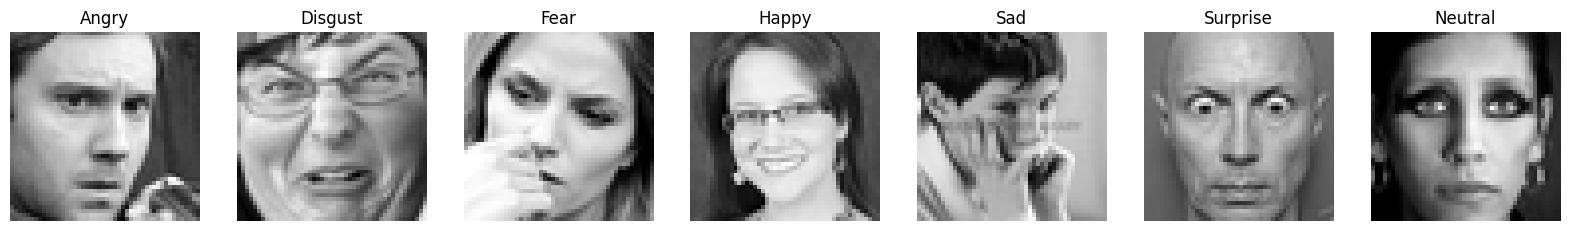

In [11]:
# Visualize an image from each class of emotions before model training
def plot_class_samples(x_train, y_train):
    emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    fig, axes = plt.subplots(1, 7, figsize=(20, 5))
    
    for i, ax in enumerate(axes):
        # Find the first image in x_train that corresponds to each emotion class
        idx = np.argmax(y_train[:, i] == 1)
        img = x_train[idx].reshape(48, 48)
        ax.imshow(img, cmap='gray')
        ax.set_title(emotion_labels[i])
        ax.axis('off')
    
    plt.show()

plot_class_samples(x_train, y_train)

In [12]:
# Oversampling using SMOTE on training data
smote = SMOTE()
x_train_reshaped = x_train.reshape(x_train.shape[0], -1)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_reshaped, np.argmax(y_train, axis=1))
x_train_resampled = x_train_resampled.reshape(x_train_resampled.shape[0], 48, 48, 1)
y_train_resampled = to_categorical(y_train_resampled, num_classes=7)

# Data Augmentation with more variations
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(x_train_resampled)

In [13]:
# Build the model from scratch
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(7, activation='softmax')
])

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

In [15]:
# Train the model with early stopping and learning rate reduction
history = model.fit(datagen.flow(x_train_resampled, y_train_resampled, batch_size=64), 
                    validation_data=(x_val, y_val), 
                    epochs=70, 
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/70
790/790 ━━━━━━━━━━━━━━━━━━━━ 442s 552ms/step - accuracy: 0.1682 - loss: 2.6194 - val_accuracy: 0.1304 - val_loss: 2.0039 - learning_rate: 5.0000e-04
Epoch 2/70
790/790 ━━━━━━━━━━━━━━━━━━━━ 540s 683ms/step - accuracy: 0.2009 - loss: 1.9971 - val_accuracy: 0.2544 - val_loss: 1.8285 - learning_rate: 5.0000e-04
Epoch 3/70
790/790 ━━━━━━━━━━━━━━━━━━━━ 566s 716ms/step - accuracy: 0.2526 - loss: 1.8646 - val_accuracy: 0.2747 - val_loss: 1.7947 - learning_rate: 5.0000e-04
Epoch 4/70
790/790 ━━━━━━━━━━━━━━━━━━━━ 587s 742ms/step - accuracy: 0.3126 - loss: 1.7492 - val_accuracy: 0.3547 - val_loss: 1.6614 - learning_rate: 5.0000e-04
Epoch 5/70
790/790 ━━━━━━━━━━━━━━━━━━━━ 597s 755ms/step - accuracy: 0.3636 - loss: 1.6480 - val_accuracy: 0.4586 - val_loss: 1.3871 - learning_rate: 5.0000e-04
Epoch 6/70
790/790 ━━━━━━━━━━━━━━━━━━━━ 616s 779ms/step - accuracy: 0.4069 - loss: 1.5445 - val_accuracy: 0.4631 - val_loss: 1.3744 - learning_rate: 5.0000e-04
Epoch 7/70
790/790 ━━━━━━━━━━━━━━━━━━━━ 

In [16]:
# Save the model
model_json = model.to_json()
with open("models/emotion_model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("models/emotion_model.weights.h5")

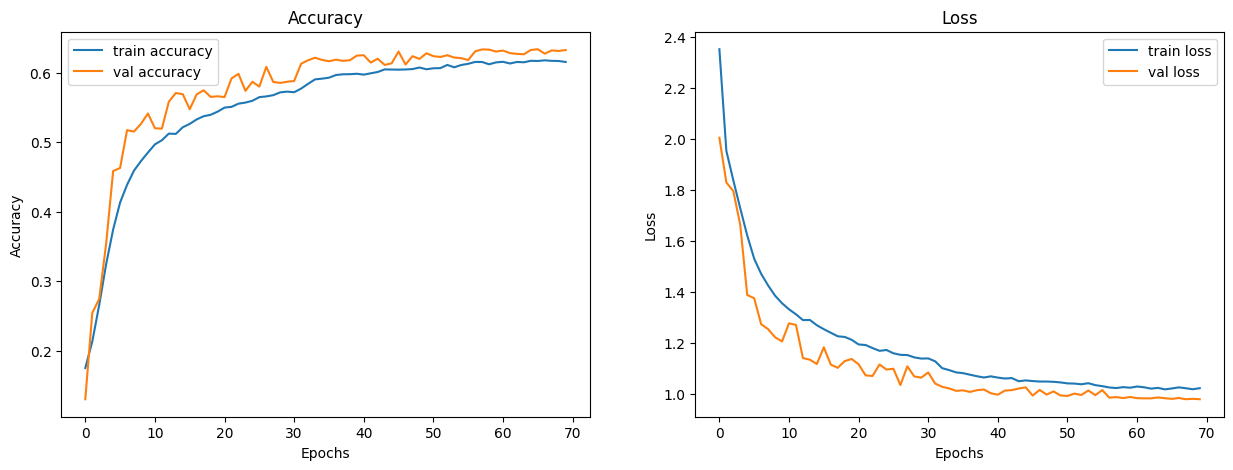

In [17]:
# Plot accuracy and loss
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax[0].plot(history.history['accuracy'], label='train accuracy')
    ax[0].plot(history.history['val_accuracy'], label='val accuracy')
    ax[0].set_title('Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()
    
    # Plot loss
    ax[1].plot(history.history['loss'], label='train loss')
    ax[1].plot(history.history['val_loss'], label='val loss')
    ax[1].set_title('Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()
    
    plt.show()

plot_history(history)



In [18]:
# Evaluate on training set
train_loss, train_accuracy = model.evaluate(x_train, y_train, verbose=0)
print(f'Training accuracy: {train_accuracy:.4f}')

# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(x_val, y_val, verbose=0)
print(f'Validation accuracy: {val_accuracy:.4f}')

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f'Test accuracy: {test_accuracy:.4f}')

Training accuracy: 0.6731
Validation accuracy: 0.6328
Test accuracy: 0.6523


113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step
Classification Report:
               precision    recall  f1-score   support

       Angry       0.59      0.58      0.59       491
     Disgust       0.49      0.73      0.59        55
        Fear       0.59      0.27      0.38       528
       Happy       0.85      0.89      0.87       879
         Sad       0.51      0.49      0.50       594
    Surprise       0.74      0.77      0.76       416
     Neutral       0.56      0.76      0.64       626

    accuracy                           0.65      3589
   macro avg       0.62      0.64      0.62      3589
weighted avg       0.65      0.65      0.64      3589



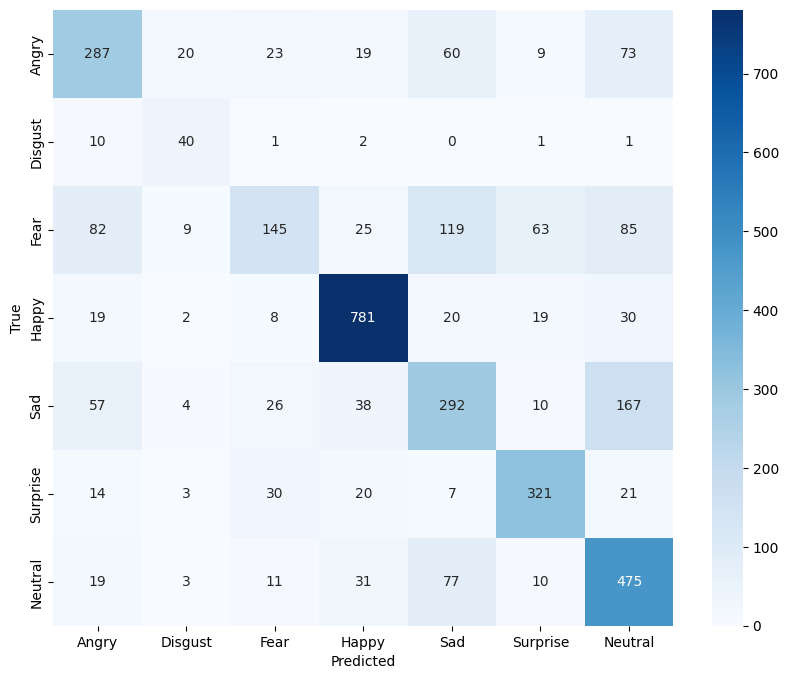

In [22]:
# Generate predictions for the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Define emotion labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Classification report
print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=emotion_labels))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [23]:
# Calculate accuracy percentages for each emotion
emotion_accuracies = {}
for i, label in enumerate(emotion_labels):
    accuracy = conf_matrix[i, i] / np.sum(conf_matrix[i]) * 100
    emotion_accuracies[label] = accuracy

# Display the accuracy percentages for each emotion
print("\nAccuracy percentages for each emotion:")
for emotion, accuracy in emotion_accuracies.items():
    print(f"{emotion}: {accuracy:.2f}%")


Accuracy percentages for each emotion:
Angry: 58.45%
Disgust: 72.73%
Fear: 27.46%
Happy: 88.85%
Sad: 49.16%
Surprise: 77.16%
Neutral: 75.88%
